In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
EMBEDDING_DIM = 64
MAX_SEQ_LENGTH = 64
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
def build_vocab(text_columns):
    vocab = {'<pad>': 0, '<unk>': 1, '<sep>': 2}
    index = 3
    for col in text_columns:
        for text in df[col]:
            for word in str(text).split():
                if word not in vocab:
                    vocab[word] = index
                    index += 1
    return vocab

# Custom Dataset

In [5]:
class URLDataset(Dataset):
    def __init__(self, texts, numerical_features, labels, vocab, max_length):
        # Convert text columns to numpy arrays to avoid pandas indexing issues
        self.texts = {col: texts[col].values for col in text_columns}
        self.numerical = numerical_features
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Process text components using direct array access
        combined_text = ' <sep> '.join([str(self.texts[col][idx]) for col in text_columns])
        tokenized = [self.vocab.get(word, 0) for word in combined_text.split()[:self.max_length]]
        padded = tokenized + [0]*(self.max_length - len(tokenized))
        
        return {
            'text': torch.LongTensor(padded),
            'numerical': torch.FloatTensor(self.numerical[idx]),
            'label': torch.LongTensor([self.labels[idx]])
        }

# Custom ANN Model

In [6]:
class URLClassifierANN(nn.Module):
    def __init__(self, vocab_size, num_numerical_features, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.fc = nn.Sequential(
            nn.Linear(EMBEDDING_DIM + num_numerical_features, 16),
            nn.BatchNorm1d(16), 
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(16, num_classes)
        )

    def forward(self, text, numerical):
        embedded = self.embedding(text).mean(dim=1)  # Average pooling
        combined = torch.cat([embedded, numerical], dim=1)
        return self.fc(combined)

# Custom CNN Model

In [7]:
class URLClassifierCNN(nn.Module):
    def __init__(self, vocab_size, num_numerical_features, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)

        self.conv = nn.Sequential(
            nn.Conv1d(EMBEDDING_DIM, 64, kernel_size=3),
            nn.BatchNorm1d(64),  # Normalize conv outputs
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)  # Regularization
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * ((MAX_SEQ_LENGTH - 2) // 2) + num_numerical_features, 32),  # Dynamic size
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, text, numerical):
        embedded = self.embedding(text).permute(0, 2, 1)  # (batch, channels, seq_len)
        conv_out = self.conv(embedded).flatten(start_dim=1)
        combined = torch.cat([conv_out, numerical], dim=1)
        return self.fc(combined)

# Custom LSTM Model

In [8]:
class URLClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, num_numerical_features, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBEDDING_DIM)
        self.lstm = nn.LSTM(EMBEDDING_DIM, 64, bidirectional=True, batch_first=True, dropout=0.3)  # Dropout between LSTM layers
        self.fc = nn.Sequential(
            nn.Linear(128 + num_numerical_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),  # Stronger regularization in FC layer
            nn.Linear(64, num_classes)
        )

    def forward(self, text, numerical):
        embedded = self.embedding(text)
        lstm_out, (h_n, c_n) = self.lstm(embedded)
        lstm_features = torch.cat([h_n[-2], h_n[-1]], dim=1)  # Get last hidden states
        combined = torch.cat([lstm_features, numerical], dim=1)
        return self.fc(combined)

# Training Code

In [9]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    scheduler=None,
    epochs=10,
    early_stop_patience=3,
    best_checkpoint_path="./Models/best_model.pth"
):
    """
    Train and validate a model with metrics tracking, checkpointing, and early stopping
    
    Args:
        model: PyTorch model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        optimizer: Optimizer instance
        criterion: Loss function
        device: Target device (cpu/cuda)
        scheduler: Learning rate scheduler (optional)
        epochs: Maximum number of epochs
        early_stop_patience: Early stopping patience
        best_checkpoint_path: Path to save best model
        last_checkpoint_path: Path to save last model
    
    Returns:
        Dictionary containing training metrics
    """
    
    # Initialize metrics tracking
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'train_f1': [],
        'val_f1': []
    }
    
    best_f1 = 0.0
    stop_count = 0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        train_preds, train_labels = [], []
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1} Training'):
            
            optimizer.zero_grad()
            outputs = model(batch['text'].to(device), batch['numerical'].to(device))
            loss = criterion(outputs, batch['label'].squeeze().to(device))
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            preds = torch.argmax(torch.softmax(outputs, dim=-1), dim=-1)
            
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(batch['label'].squeeze().cpu().numpy())
        
        # Update scheduler if provided
        if scheduler:
            scheduler.step()
            
        # Calculate training metrics
        train_loss = epoch_train_loss / len(train_loader)
        train_acc = accuracy_score(train_labels, train_preds) * 100
        train_f1 = f1_score(train_labels, train_preds, average='weighted') * 100
        train_precision = precision_score(train_labels, train_preds, average='weighted') * 100
        train_recall = recall_score(train_labels, train_preds, average='weighted') * 100
        
        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['train_f1'].append(train_f1)
        # metrics['train_precision'].append(train_precision)
        # metrics['train_recall'].append(train_recall)
        
        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f'Epoch {epoch+1} Validation'):
                
                outputs = model(batch['text'].unsqueeze(0).to(device), batch['numerical'].unsqueeze(0).to(device))
                loss = criterion(outputs, batch['label'].to(device))
                
                epoch_val_loss += loss.item()
                preds = torch.argmax(torch.softmax(outputs, dim=-1), dim=-1)
                
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(batch['label'].cpu().numpy())
        
        # Calculate validation metrics
        val_loss = epoch_val_loss / len(val_loader)
        val_acc = accuracy_score(val_labels, val_preds) * 100
        val_f1 = f1_score(val_labels, val_preds, average='weighted') * 100
        val_precision = precision_score(val_labels, val_preds, average='weighted') * 100
        val_recall = recall_score(val_labels, val_preds, average='weighted') * 100
        
        metrics['val_loss'].append(val_loss)
        metrics['val_acc'].append(val_acc)
        metrics['val_f1'].append(val_f1)
        # metrics['val_precision'].append(val_precision)
        # metrics['val_recall'].append(val_recall)
        cm = confusion_matrix
        
        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
        print(f"Train F1: {train_precision:.2f}% | Val F1: {val_precision:.2f}%")
        print(f"Train F1: {train_recall:.2f}% | Val F1: {val_recall:.2f}%")
        print(f"Train F1: {train_f1:.2f}% | Val F1: {val_f1:.2f}%")
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), best_checkpoint_path)
            print(f"New best model saved with Val F1: {best_f1:.2f}%")
            stop_count = 0
        else:
            stop_count += 1
            if stop_count >= early_stop_patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs!")
                break
    
    print(f"\nTraining completed. Best Validation F1: {best_f1:.2f}%")
    return metrics

In [10]:
df = pd.read_csv('./Data/Balanced_dataset.csv')
df.head()

,url,type,scheme,domain,subdomain,top_level_domain,path,path_length,num_path_segments,query_params,num_query_params,has_https,file_extension,has_fragment,has_special_chars_in_path,has_port,port_number,is_ip_address
0,https://ethnicelebs.com/eddie-anderson-comedian,benign,https,ethnicelebs.com,none,com,/eddie-anderson-comedian,24,1,0,0,1,none,0,0,0,0,0
1,https://closinglogos.com/page/Sony+Pictures+Ho...,benign,https,closinglogos.com,none,com,/page/Sony+Pictures+Home+Entertainment+Warning...,53,2,0,0,1,none,0,0,0,0,0
2,https://terezowens.com/golfer-greg-norman-tryi...,benign,https,terezowens.com,none,com,/golfer-greg-norman-trying-to-unload-55-millio...,54,1,0,0,1,none,0,0,0,0,0
3,https://americannortel.com/,benign,https,americannortel.com,none,com,/,1,0,0,0,1,none,0,0,0,0,0
4,https://welding.org/,benign,https,welding.org,none,org,/,1,0,0,0,1,none,0,0,0,0,0


In [11]:
text_columns = ['url', 'scheme', 'domain', 'subdomain', 'top_level_domain', 'path', 'file_extension']
numerical_columns = ['path_length', 'num_path_segments', 'query_params','num_query_params','has_fragment', 'has_special_chars_in_path']

# Encode labels
le = LabelEncoder()
df['type'] = le.fit_transform(df['type'])

# Normalize numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(df[numerical_columns])

# Build vocabulary
vocab = build_vocab(text_columns)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    np.arange(len(df)), df['type'].values, test_size=0.2, random_state=42
)

# Create datasets with corrected text handling
train_dataset = URLDataset(
    texts={col: df[col].iloc[X_train] for col in text_columns},
    numerical_features=numerical_features[X_train],
    labels=y_train,
    vocab=vocab,
    max_length=MAX_SEQ_LENGTH
)

test_dataset = URLDataset(
    texts={col: df[col].iloc[X_test] for col in text_columns},
    numerical_features=numerical_features[X_test],
    labels=y_test,
    vocab=vocab,
    max_length=MAX_SEQ_LENGTH
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialize models
num_classes = len(le.classes_)

In [12]:
train_dataset[7]

{'text': tensor([24769,     2, 51063,     2, 61016,     2, 71868,     2, 75904,     2,
         78222,     2, 71868,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'numerical': tensor([-1.0340, -1.4405, -0.4953, -0.4938, -0.0281, -0.1577]),
 'label': tensor([3])}

In [13]:
ann_model = URLClassifierANN(len(vocab), len(numerical_columns), num_classes)
optimizer = torch.optim.Adam(ann_model.parameters(), lr=0.0009)
criterion = torch.nn.CrossEntropyLoss()

ann_model.to(DEVICE)

# Train the model
metrics = train_model(
    model=ann_model,
    train_loader=train_loader,
    val_loader=test_dataset,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    epochs=20,
    early_stop_patience=5,
    best_checkpoint_path="./Models/best_ann.pth",
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:08<00:00, 1426.72it/s]



Epoch 1/20
Train Loss: 0.7272 | Val Loss: 0.3944
Train Acc: 74.25% | Val Acc: 85.86%
Train F1: 73.93% | Val F1: 85.78%
Train F1: 74.25% | Val F1: 85.86%
Train F1: 73.99% | Val F1: 85.76%
New best model saved with Val F1: 85.76%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1688.68it/s]



Epoch 2/20
Train Loss: 0.4447 | Val Loss: 0.3353
Train Acc: 84.57% | Val Acc: 87.62%
Train F1: 84.37% | Val F1: 87.57%
Train F1: 84.57% | Val F1: 87.62%
Train F1: 84.43% | Val F1: 87.57%
New best model saved with Val F1: 87.57%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1521.59it/s]



Epoch 3/20
Train Loss: 0.3646 | Val Loss: 0.3060
Train Acc: 87.42% | Val Acc: 88.62%
Train F1: 87.34% | Val F1: 88.86%
Train F1: 87.42% | Val F1: 88.62%
Train F1: 87.36% | Val F1: 88.71%
New best model saved with Val F1: 88.71%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1595.41it/s]



Epoch 4/20
Train Loss: 0.3081 | Val Loss: 0.2949
Train Acc: 89.37% | Val Acc: 88.66%
Train F1: 89.33% | Val F1: 88.78%
Train F1: 89.37% | Val F1: 88.66%
Train F1: 89.34% | Val F1: 88.58%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:06<00:00, 1782.21it/s]



Epoch 5/20
Train Loss: 0.2564 | Val Loss: 0.2909
Train Acc: 91.40% | Val Acc: 89.08%
Train F1: 91.37% | Val F1: 89.36%
Train F1: 91.40% | Val F1: 89.08%
Train F1: 91.38% | Val F1: 89.13%
New best model saved with Val F1: 89.13%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:08<00:00, 1431.69it/s]



Epoch 6/20
Train Loss: 0.2081 | Val Loss: 0.2953
Train Acc: 93.28% | Val Acc: 89.40%
Train F1: 93.28% | Val F1: 89.57%
Train F1: 93.28% | Val F1: 89.40%
Train F1: 93.28% | Val F1: 89.45%
New best model saved with Val F1: 89.45%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1527.39it/s]



Epoch 7/20
Train Loss: 0.1694 | Val Loss: 0.3044
Train Acc: 94.66% | Val Acc: 89.32%
Train F1: 94.66% | Val F1: 89.39%
Train F1: 94.66% | Val F1: 89.32%
Train F1: 94.66% | Val F1: 89.32%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:08<00:00, 1341.53it/s]



Epoch 8/20
Train Loss: 0.1331 | Val Loss: 0.3471
Train Acc: 95.92% | Val Acc: 88.98%
Train F1: 95.92% | Val F1: 89.12%
Train F1: 95.92% | Val F1: 88.98%
Train F1: 95.92% | Val F1: 88.96%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1686.03it/s]



Epoch 9/20
Train Loss: 0.1073 | Val Loss: 0.3673
Train Acc: 96.76% | Val Acc: 88.90%
Train F1: 96.77% | Val F1: 89.34%
Train F1: 96.76% | Val F1: 88.90%
Train F1: 96.76% | Val F1: 89.03%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:06<00:00, 1764.22it/s]



Epoch 10/20
Train Loss: 0.0881 | Val Loss: 0.4104
Train Acc: 97.38% | Val Acc: 88.25%
Train F1: 97.38% | Val F1: 88.54%
Train F1: 97.38% | Val F1: 88.25%
Train F1: 97.38% | Val F1: 88.28%


Epoch 11 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:07<00:00, 1630.21it/s]


Epoch 11/20
Train Loss: 0.0703 | Val Loss: 0.4422
Train Acc: 97.84% | Val Acc: 88.21%
Train F1: 97.84% | Val F1: 88.22%
Train F1: 97.84% | Val F1: 88.21%
Train F1: 97.84% | Val F1: 88.21%

Early stopping triggered after 11 epochs!

Training completed. Best Validation F1: 89.45%


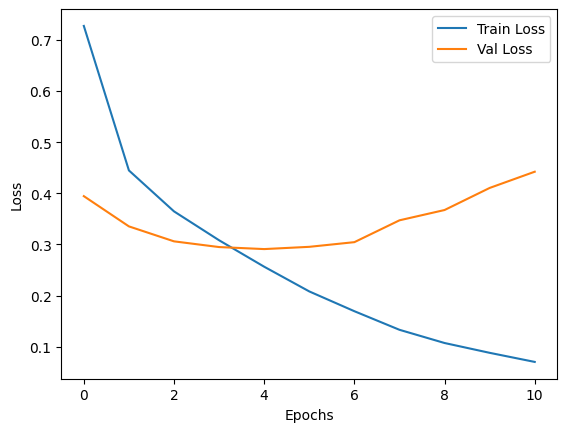

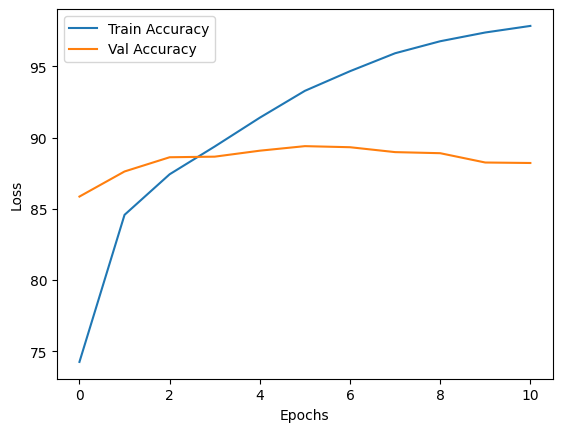

In [14]:
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
cnn_model = URLClassifierCNN(len(vocab), len(numerical_columns), num_classes)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

cnn_model.to(DEVICE)

# Train the model
metrics = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=test_dataset,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    epochs=20,
    early_stop_patience=5,
    best_checkpoint_path="./Models/best_cnn.pth",
)

Epoch 1 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1156.86it/s]



Epoch 1/20
Train Loss: 0.8435 | Val Loss: 0.5058
Train Acc: 72.51% | Val Acc: 83.62%
Train F1: 72.00% | Val F1: 83.75%
Train F1: 72.51% | Val F1: 83.62%
Train F1: 71.80% | Val F1: 83.26%
New best model saved with Val F1: 83.26%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1140.27it/s]



Epoch 2/20
Train Loss: 0.5605 | Val Loss: 0.3943
Train Acc: 81.85% | Val Acc: 85.73%
Train F1: 81.62% | Val F1: 85.70%
Train F1: 81.85% | Val F1: 85.73%
Train F1: 81.49% | Val F1: 85.47%
New best model saved with Val F1: 85.47%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:11<00:00, 1054.26it/s]



Epoch 3/20
Train Loss: 0.4831 | Val Loss: 0.3558
Train Acc: 83.04% | Val Acc: 86.07%
Train F1: 82.77% | Val F1: 86.05%
Train F1: 83.04% | Val F1: 86.07%
Train F1: 82.75% | Val F1: 85.82%
New best model saved with Val F1: 85.82%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:11<00:00, 1075.60it/s]



Epoch 4/20
Train Loss: 0.4385 | Val Loss: 0.3269
Train Acc: 84.37% | Val Acc: 87.24%
Train F1: 84.15% | Val F1: 87.14%
Train F1: 84.37% | Val F1: 87.24%
Train F1: 84.14% | Val F1: 87.04%
New best model saved with Val F1: 87.04%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1283.31it/s]



Epoch 5/20
Train Loss: 0.4141 | Val Loss: 0.3141
Train Acc: 85.15% | Val Acc: 88.08%
Train F1: 84.98% | Val F1: 88.19%
Train F1: 85.15% | Val F1: 88.08%
Train F1: 84.97% | Val F1: 88.03%
New best model saved with Val F1: 88.03%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1232.64it/s]



Epoch 6/20
Train Loss: 0.3896 | Val Loss: 0.2986
Train Acc: 85.77% | Val Acc: 88.56%
Train F1: 85.65% | Val F1: 88.59%
Train F1: 85.77% | Val F1: 88.56%
Train F1: 85.64% | Val F1: 88.47%
New best model saved with Val F1: 88.47%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1085.85it/s]



Epoch 7/20
Train Loss: 0.3747 | Val Loss: 0.2922
Train Acc: 86.46% | Val Acc: 89.06%
Train F1: 86.37% | Val F1: 89.10%
Train F1: 86.46% | Val F1: 89.06%
Train F1: 86.36% | Val F1: 88.98%
New best model saved with Val F1: 88.98%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1085.07it/s]



Epoch 8/20
Train Loss: 0.3601 | Val Loss: 0.2811
Train Acc: 86.78% | Val Acc: 89.30%
Train F1: 86.69% | Val F1: 89.39%
Train F1: 86.78% | Val F1: 89.30%
Train F1: 86.69% | Val F1: 89.28%
New best model saved with Val F1: 89.28%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1258.25it/s]



Epoch 9/20
Train Loss: 0.3520 | Val Loss: 0.2759
Train Acc: 87.13% | Val Acc: 89.31%
Train F1: 87.10% | Val F1: 89.46%
Train F1: 87.13% | Val F1: 89.31%
Train F1: 87.08% | Val F1: 89.28%
New best model saved with Val F1: 89.28%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1259.91it/s]



Epoch 10/20
Train Loss: 0.3364 | Val Loss: 0.2653
Train Acc: 87.64% | Val Acc: 89.76%
Train F1: 87.61% | Val F1: 89.81%
Train F1: 87.64% | Val F1: 89.76%
Train F1: 87.60% | Val F1: 89.74%
New best model saved with Val F1: 89.74%


Epoch 11 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1115.33it/s]



Epoch 11/20
Train Loss: 0.3279 | Val Loss: 0.2604
Train Acc: 87.86% | Val Acc: 89.92%
Train F1: 87.84% | Val F1: 90.06%
Train F1: 87.86% | Val F1: 89.92%
Train F1: 87.83% | Val F1: 89.92%
New best model saved with Val F1: 89.92%


Epoch 12 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1099.88it/s]



Epoch 12/20
Train Loss: 0.3188 | Val Loss: 0.2573
Train Acc: 88.20% | Val Acc: 90.09%
Train F1: 88.20% | Val F1: 90.20%
Train F1: 88.20% | Val F1: 90.09%
Train F1: 88.17% | Val F1: 90.09%
New best model saved with Val F1: 90.09%


Epoch 13 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1085.86it/s]



Epoch 13/20
Train Loss: 0.3079 | Val Loss: 0.2533
Train Acc: 88.44% | Val Acc: 90.19%
Train F1: 88.44% | Val F1: 90.42%
Train F1: 88.44% | Val F1: 90.19%
Train F1: 88.42% | Val F1: 90.21%
New best model saved with Val F1: 90.21%


Epoch 14 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1290.04it/s]



Epoch 14/20
Train Loss: 0.3013 | Val Loss: 0.2463
Train Acc: 88.89% | Val Acc: 90.37%
Train F1: 88.89% | Val F1: 90.47%
Train F1: 88.89% | Val F1: 90.37%
Train F1: 88.87% | Val F1: 90.37%
New best model saved with Val F1: 90.37%


Epoch 15 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1269.50it/s]



Epoch 15/20
Train Loss: 0.2984 | Val Loss: 0.2444
Train Acc: 88.85% | Val Acc: 90.50%
Train F1: 88.88% | Val F1: 90.69%
Train F1: 88.85% | Val F1: 90.50%
Train F1: 88.84% | Val F1: 90.54%
New best model saved with Val F1: 90.54%


Epoch 16 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1248.70it/s]



Epoch 16/20
Train Loss: 0.2877 | Val Loss: 0.2427
Train Acc: 89.28% | Val Acc: 90.49%
Train F1: 89.32% | Val F1: 90.79%
Train F1: 89.28% | Val F1: 90.49%
Train F1: 89.28% | Val F1: 90.59%
New best model saved with Val F1: 90.59%


Epoch 17 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1258.28it/s]



Epoch 17/20
Train Loss: 0.2766 | Val Loss: 0.2386
Train Acc: 89.74% | Val Acc: 90.68%
Train F1: 89.80% | Val F1: 90.86%
Train F1: 89.74% | Val F1: 90.68%
Train F1: 89.75% | Val F1: 90.73%
New best model saved with Val F1: 90.73%


Epoch 18 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1283.13it/s]



Epoch 18/20
Train Loss: 0.2781 | Val Loss: 0.2379
Train Acc: 89.64% | Val Acc: 90.74%
Train F1: 89.70% | Val F1: 90.85%
Train F1: 89.64% | Val F1: 90.74%
Train F1: 89.65% | Val F1: 90.76%
New best model saved with Val F1: 90.76%


Epoch 19 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1285.69it/s]



Epoch 19/20
Train Loss: 0.2697 | Val Loss: 0.2350
Train Acc: 89.92% | Val Acc: 90.78%
Train F1: 89.97% | Val F1: 90.88%
Train F1: 89.92% | Val F1: 90.78%
Train F1: 89.92% | Val F1: 90.79%
New best model saved with Val F1: 90.79%


Epoch 20 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1228.66it/s]



Epoch 20/20
Train Loss: 0.2615 | Val Loss: 0.2361
Train Acc: 90.26% | Val Acc: 90.84%
Train F1: 90.32% | Val F1: 91.01%
Train F1: 90.26% | Val F1: 90.84%
Train F1: 90.27% | Val F1: 90.89%
New best model saved with Val F1: 90.89%

Training completed. Best Validation F1: 90.89%


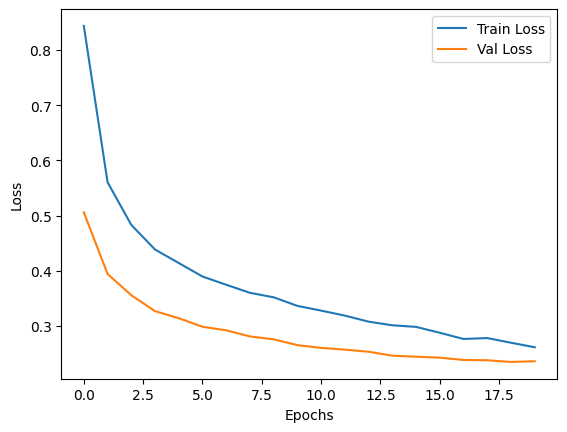

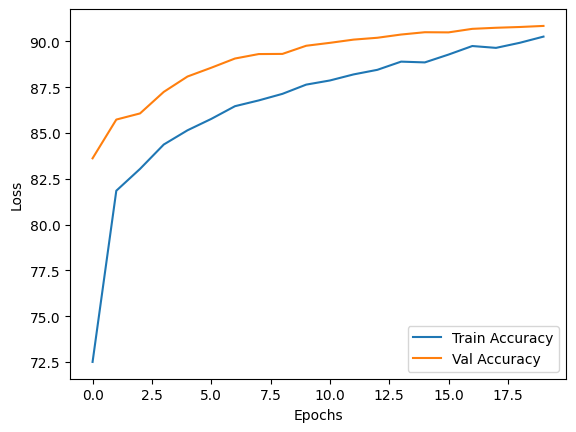

In [16]:
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
lstm_model = URLClassifierLSTM(len(vocab), len(numerical_columns), num_classes)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

lstm_model.to(DEVICE)

# Train the model
metrics = train_model(
    model=lstm_model,
    train_loader=train_loader,
    val_loader=test_dataset,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    epochs=20,
    early_stop_patience=5,
    best_checkpoint_path="./Models/best_lstm.pth",
)

C:\Users\syeda\miniconda3\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
Epoch 1 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1165.93it/s]



Epoch 1/20
Train Loss: 1.0004 | Val Loss: 0.5395
Train Acc: 61.45% | Val Acc: 81.29%
Train F1: 61.79% | Val F1: 81.14%
Train F1: 61.45% | Val F1: 81.29%
Train F1: 61.33% | Val F1: 80.93%
New best model saved with Val F1: 80.93%


Epoch 2 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:08<00:00, 1425.34it/s]



Epoch 2/20
Train Loss: 0.5250 | Val Loss: 0.4143
Train Acc: 82.10% | Val Acc: 84.38%
Train F1: 82.14% | Val F1: 84.62%
Train F1: 82.10% | Val F1: 84.38%
Train F1: 81.83% | Val F1: 84.08%
New best model saved with Val F1: 84.08%


Epoch 3 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:08<00:00, 1468.44it/s]



Epoch 3/20
Train Loss: 0.4312 | Val Loss: 0.3756
Train Acc: 84.83% | Val Acc: 85.88%
Train F1: 84.76% | Val F1: 86.35%
Train F1: 84.83% | Val F1: 85.88%
Train F1: 84.67% | Val F1: 85.95%
New best model saved with Val F1: 85.95%


Epoch 4 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:08<00:00, 1437.52it/s]



Epoch 4/20
Train Loss: 0.3799 | Val Loss: 0.3402
Train Acc: 86.57% | Val Acc: 86.86%
Train F1: 86.54% | Val F1: 87.11%
Train F1: 86.57% | Val F1: 86.86%
Train F1: 86.49% | Val F1: 86.90%
New best model saved with Val F1: 86.90%


Epoch 5 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:08<00:00, 1410.45it/s]



Epoch 5/20
Train Loss: 0.3484 | Val Loss: 0.3241
Train Acc: 87.60% | Val Acc: 87.48%
Train F1: 87.62% | Val F1: 87.55%
Train F1: 87.60% | Val F1: 87.48%
Train F1: 87.57% | Val F1: 87.42%
New best model saved with Val F1: 87.42%


Epoch 6 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:08<00:00, 1376.90it/s]



Epoch 6/20
Train Loss: 0.3285 | Val Loss: 0.3078
Train Acc: 88.05% | Val Acc: 87.96%
Train F1: 88.09% | Val F1: 88.07%
Train F1: 88.05% | Val F1: 87.96%
Train F1: 88.04% | Val F1: 87.95%
New best model saved with Val F1: 87.95%


Epoch 7 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1317.95it/s]



Epoch 7/20
Train Loss: 0.3092 | Val Loss: 0.3008
Train Acc: 88.75% | Val Acc: 88.08%
Train F1: 88.80% | Val F1: 88.12%
Train F1: 88.75% | Val F1: 88.08%
Train F1: 88.75% | Val F1: 88.02%
New best model saved with Val F1: 88.02%


Epoch 8 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1216.34it/s]



Epoch 8/20
Train Loss: 0.2958 | Val Loss: 0.2958
Train Acc: 89.27% | Val Acc: 88.37%
Train F1: 89.31% | Val F1: 88.45%
Train F1: 89.27% | Val F1: 88.37%
Train F1: 89.26% | Val F1: 88.40%
New best model saved with Val F1: 88.40%


Epoch 9 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1319.21it/s]



Epoch 9/20
Train Loss: 0.2806 | Val Loss: 0.2905
Train Acc: 89.76% | Val Acc: 88.88%
Train F1: 89.81% | Val F1: 89.07%
Train F1: 89.76% | Val F1: 88.88%
Train F1: 89.77% | Val F1: 88.89%
New best model saved with Val F1: 88.89%


Epoch 10 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:11<00:00, 1049.35it/s]



Epoch 10/20
Train Loss: 0.2654 | Val Loss: 0.2754
Train Acc: 90.35% | Val Acc: 89.41%
Train F1: 90.42% | Val F1: 89.52%
Train F1: 90.35% | Val F1: 89.41%
Train F1: 90.37% | Val F1: 89.44%
New best model saved with Val F1: 89.44%


Epoch 11 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:11<00:00, 1072.90it/s]



Epoch 11/20
Train Loss: 0.2552 | Val Loss: 0.2699
Train Acc: 90.77% | Val Acc: 89.51%
Train F1: 90.85% | Val F1: 89.60%
Train F1: 90.77% | Val F1: 89.51%
Train F1: 90.79% | Val F1: 89.54%
New best model saved with Val F1: 89.54%


Epoch 12 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:10<00:00, 1175.50it/s]



Epoch 12/20
Train Loss: 0.2435 | Val Loss: 0.2826
Train Acc: 91.19% | Val Acc: 88.63%
Train F1: 91.25% | Val F1: 89.10%
Train F1: 91.19% | Val F1: 88.63%
Train F1: 91.20% | Val F1: 88.78%


Epoch 13 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:09<00:00, 1251.13it/s]



Epoch 13/20
Train Loss: 0.2340 | Val Loss: 0.2675
Train Acc: 91.66% | Val Acc: 89.71%
Train F1: 91.73% | Val F1: 89.66%
Train F1: 91.66% | Val F1: 89.71%
Train F1: 91.68% | Val F1: 89.64%
New best model saved with Val F1: 89.64%


Epoch 14 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:11<00:00, 1007.30it/s]



Epoch 14/20
Train Loss: 0.2232 | Val Loss: 0.2673
Train Acc: 92.05% | Val Acc: 89.57%
Train F1: 92.11% | Val F1: 89.73%
Train F1: 92.05% | Val F1: 89.57%
Train F1: 92.06% | Val F1: 89.60%


Epoch 15 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:11<00:00, 996.73it/s]



Epoch 15/20
Train Loss: 0.2121 | Val Loss: 0.2719
Train Acc: 92.33% | Val Acc: 89.61%
Train F1: 92.39% | Val F1: 90.06%
Train F1: 92.33% | Val F1: 89.61%
Train F1: 92.34% | Val F1: 89.67%
New best model saved with Val F1: 89.67%


Epoch 16 Validation: 100%|█████████████████████████████████████████████████████| 11921/11921 [00:08<00:00, 1404.10it/s]



Epoch 16/20
Train Loss: 0.2028 | Val Loss: 0.2559
Train Acc: 92.71% | Val Acc: 90.33%
Train F1: 92.77% | Val F1: 90.37%
Train F1: 92.71% | Val F1: 90.33%
Train F1: 92.73% | Val F1: 90.33%
New best model saved with Val F1: 90.33%


Epoch 17 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:16<00:00, 742.07it/s]



Epoch 17/20
Train Loss: 0.1926 | Val Loss: 0.2631
Train Acc: 93.02% | Val Acc: 90.13%
Train F1: 93.09% | Val F1: 90.27%
Train F1: 93.02% | Val F1: 90.13%
Train F1: 93.04% | Val F1: 90.14%


Epoch 18 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:39<00:00, 302.98it/s]



Epoch 18/20
Train Loss: 0.1847 | Val Loss: 0.2615
Train Acc: 93.27% | Val Acc: 90.32%
Train F1: 93.33% | Val F1: 90.37%
Train F1: 93.27% | Val F1: 90.32%
Train F1: 93.29% | Val F1: 90.31%


Epoch 19 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:39<00:00, 302.85it/s]



Epoch 19/20
Train Loss: 0.1767 | Val Loss: 0.2659
Train Acc: 93.70% | Val Acc: 90.11%
Train F1: 93.76% | Val F1: 90.47%
Train F1: 93.70% | Val F1: 90.11%
Train F1: 93.72% | Val F1: 90.25%


Epoch 20 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:39<00:00, 302.93it/s]


Epoch 20/20
Train Loss: 0.1664 | Val Loss: 0.2808
Train Acc: 94.05% | Val Acc: 89.68%
Train F1: 94.11% | Val F1: 90.08%
Train F1: 94.05% | Val F1: 89.68%
Train F1: 94.07% | Val F1: 89.80%

Training completed. Best Validation F1: 90.33%


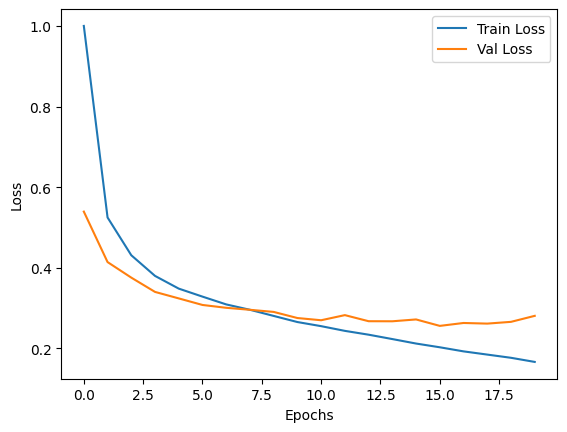

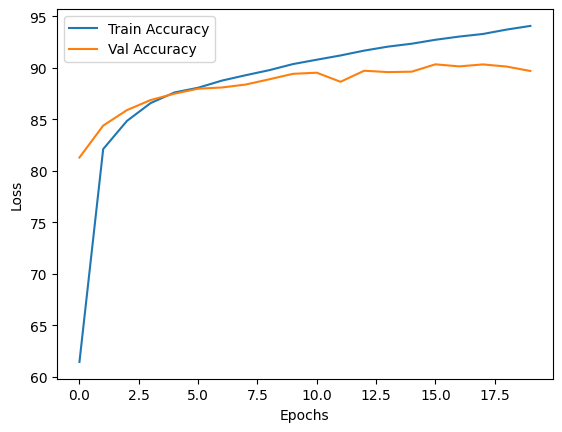

In [18]:
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# With word2vec

In [20]:
# Train Word2Vec embeddings
def train_word2vec(text_columns, vector_size=100, window=5, min_count=1):
    # Create training corpus
    sentences = []
    for col in text_columns:
        sentences += [str(text).split() for text in df[col]]
    
    # Train Word2Vec model
    model = Word2Vec(sentences=sentences,
                     vector_size=vector_size,
                     window=window,
                     min_count=min_count,
                     workers=4)
    return model

# Create embedding matrix
def create_embedding_matrix(word2vec_model, vocab):
    embedding_dim = word2vec_model.vector_size
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    
    for word, idx in vocab.items():
        if word in word2vec_model.wv:
            embedding_matrix[idx] = word2vec_model.wv[word]
        else:
            # Handle unknown words (random initialization with scaling)
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
    
    return torch.FloatTensor(embedding_matrix)

In [21]:
class URLClassifierW2V(nn.Module):
    def __init__(self, embedding_matrix, num_numerical_features, num_classes):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)
        self.fc = nn.Sequential(
            nn.Linear(embedding_matrix.size(1) + num_numerical_features, 128),
            nn.BatchNorm1d(128), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, text, numerical):
        embedded = self.embedding(text).mean(dim=1)
        combined = torch.cat([embedded, numerical], dim=1)
        return self.fc(combined)

In [22]:
# Train Word2Vec
w2v_model = train_word2vec(text_columns)

# Create embedding matrix
embedding_matrix = create_embedding_matrix(w2v_model, vocab)

In [23]:
# Initialize models with Word2Vec embeddings
w2v_ann_model = URLClassifierW2V(embedding_matrix, len(numerical_columns), num_classes)

optimizer = torch.optim.Adam(w2v_ann_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

w2v_ann_model.to(DEVICE)

metrics = train_model(
    model=w2v_ann_model,
    train_loader=train_loader,
    val_loader=test_dataset,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    epochs=20,
    early_stop_patience=5,
    best_checkpoint_path="./Models/best_w2v_ann.pth",
)

Epoch 1 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:14<00:00, 797.79it/s]



Epoch 1/20
Train Loss: 0.4476 | Val Loss: 0.6993
Train Acc: 83.28% | Val Acc: 75.30%
Train F1: 83.28% | Val F1: 80.65%
Train F1: 83.28% | Val F1: 75.30%
Train F1: 83.25% | Val F1: 75.19%
New best model saved with Val F1: 75.19%


Epoch 2 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:14<00:00, 796.22it/s]



Epoch 2/20
Train Loss: 0.1141 | Val Loss: 0.3289
Train Acc: 96.17% | Val Acc: 88.93%
Train F1: 96.17% | Val F1: 91.31%
Train F1: 96.17% | Val F1: 88.93%
Train F1: 96.17% | Val F1: 88.69%
New best model saved with Val F1: 88.69%


Epoch 3 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:28<00:00, 420.66it/s]



Epoch 3/20
Train Loss: 0.0394 | Val Loss: 0.1939
Train Acc: 98.82% | Val Acc: 93.51%
Train F1: 98.82% | Val F1: 93.56%
Train F1: 98.82% | Val F1: 93.51%
Train F1: 98.82% | Val F1: 93.52%
New best model saved with Val F1: 93.52%


Epoch 4 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:28<00:00, 420.08it/s]



Epoch 4/20
Train Loss: 0.0214 | Val Loss: 0.2544
Train Acc: 99.35% | Val Acc: 92.53%
Train F1: 99.35% | Val F1: 93.11%
Train F1: 99.35% | Val F1: 92.53%
Train F1: 99.35% | Val F1: 92.40%


Epoch 5 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:28<00:00, 417.71it/s]



Epoch 5/20
Train Loss: 0.0144 | Val Loss: 0.2328
Train Acc: 99.58% | Val Acc: 93.55%
Train F1: 99.58% | Val F1: 93.75%
Train F1: 99.58% | Val F1: 93.55%
Train F1: 99.58% | Val F1: 93.59%
New best model saved with Val F1: 93.59%


Epoch 6 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:28<00:00, 419.56it/s]



Epoch 6/20
Train Loss: 0.0130 | Val Loss: 0.2725
Train Acc: 99.59% | Val Acc: 93.60%
Train F1: 99.59% | Val F1: 93.63%
Train F1: 99.59% | Val F1: 93.60%
Train F1: 99.59% | Val F1: 93.61%
New best model saved with Val F1: 93.61%


Epoch 7 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:19<00:00, 615.81it/s]



Epoch 7/20
Train Loss: 0.0134 | Val Loss: 0.2923
Train Acc: 99.61% | Val Acc: 93.60%
Train F1: 99.61% | Val F1: 93.71%
Train F1: 99.61% | Val F1: 93.60%
Train F1: 99.61% | Val F1: 93.63%
New best model saved with Val F1: 93.63%


Epoch 8 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:15<00:00, 793.86it/s]



Epoch 8/20
Train Loss: 0.0123 | Val Loss: 0.2923
Train Acc: 99.59% | Val Acc: 92.30%
Train F1: 99.59% | Val F1: 92.61%
Train F1: 99.59% | Val F1: 92.30%
Train F1: 99.59% | Val F1: 92.17%


Epoch 9 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:18<00:00, 655.72it/s]



Epoch 9/20
Train Loss: 0.0118 | Val Loss: 0.2835
Train Acc: 99.68% | Val Acc: 93.10%
Train F1: 99.68% | Val F1: 93.29%
Train F1: 99.68% | Val F1: 93.10%
Train F1: 99.68% | Val F1: 93.07%


Epoch 10 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:28<00:00, 421.10it/s]



Epoch 10/20
Train Loss: 0.0100 | Val Loss: 0.3389
Train Acc: 99.73% | Val Acc: 92.60%
Train F1: 99.73% | Val F1: 92.88%
Train F1: 99.73% | Val F1: 92.60%
Train F1: 99.73% | Val F1: 92.60%


Epoch 11 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:28<00:00, 424.57it/s]



Epoch 11/20
Train Loss: 0.0079 | Val Loss: 0.3810
Train Acc: 99.74% | Val Acc: 93.00%
Train F1: 99.74% | Val F1: 92.95%
Train F1: 99.74% | Val F1: 93.00%
Train F1: 99.74% | Val F1: 92.97%


Epoch 12 Validation: 100%|██████████████████████████████████████████████████████| 11921/11921 [00:28<00:00, 425.06it/s]


Epoch 12/20
Train Loss: 0.0079 | Val Loss: 0.3647
Train Acc: 99.78% | Val Acc: 92.63%
Train F1: 99.78% | Val F1: 92.82%
Train F1: 99.78% | Val F1: 92.63%
Train F1: 99.78% | Val F1: 92.54%

Early stopping triggered after 12 epochs!

Training completed. Best Validation F1: 93.63%


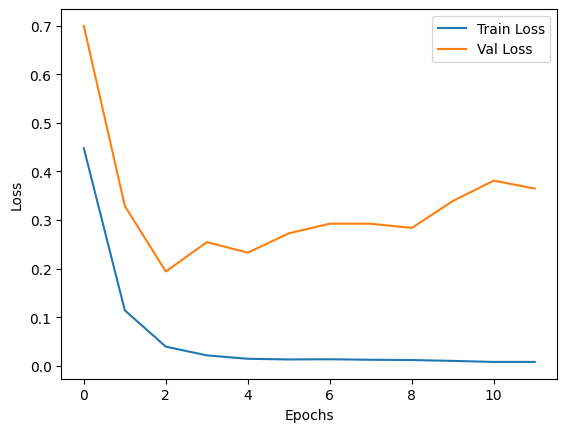

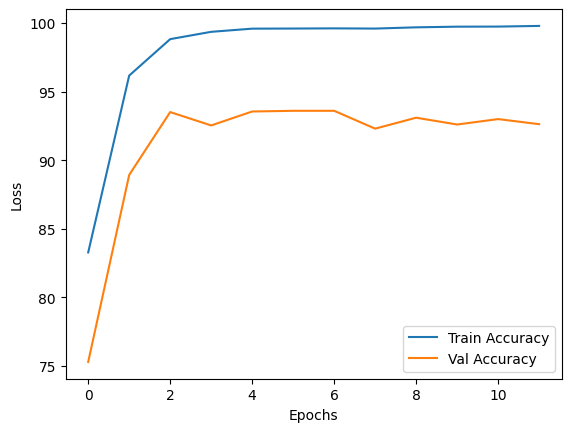

In [24]:
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
class URLClassifierW2VCNN(nn.Module):
    def __init__(self, vocab_size, num_numerical_features, num_classes):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

        self.conv = nn.Sequential(
            nn.Conv1d(EMBEDDING_DIM, 64, kernel_size=3),
            nn.BatchNorm1d(64),  # Normalize conv outputs
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)  # Regularization
        )

        self.fc = nn.Sequential(
            nn.Linear(64 * ((MAX_SEQ_LENGTH - 2) // 2) + num_numerical_features, 32),  # Dynamic size
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )

    def forward(self, text, numerical):
        embedded = self.embedding(text).permute(0, 2, 1)  # (batch, channels, seq_len)
        conv_out = self.conv(embedded).flatten(start_dim=1)
        combined = torch.cat([conv_out, numerical], dim=1)
        return self.fc(combined)

In [26]:
w2v_cnn_model = URLClassifierW2VCNN(embedding_matrix, len(numerical_columns), num_classes)

optimizer = torch.optim.Adam(w2v_cnn_model.parameters())
criterion = torch.nn.CrossEntropyLoss()

w2v_cnn_model.to(DEVICE)

metrics = train_model(
    model=w2v_ann_model,
    train_loader=train_loader,
    val_loader=test_dataset,
    optimizer=optimizer,
    criterion=criterion,
    device=DEVICE,
    epochs=20,
    early_stop_patience=5,
    best_checkpoint_path="./Models/best_w2v_cnn.pth",
)

Epoch 1 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:28<00:00, 417.12it/s]



Epoch 1/20
Train Loss: 0.0049 | Val Loss: 0.3792
Train Acc: 99.86% | Val Acc: 92.97%
Train F1: 99.86% | Val F1: 92.95%
Train F1: 99.86% | Val F1: 92.97%
Train F1: 99.86% | Val F1: 92.94%
New best model saved with Val F1: 92.94%


Epoch 2 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:17<00:00, 693.10it/s]



Epoch 2/20
Train Loss: 0.0049 | Val Loss: 0.3643
Train Acc: 99.84% | Val Acc: 93.41%
Train F1: 99.84% | Val F1: 93.46%
Train F1: 99.84% | Val F1: 93.41%
Train F1: 99.84% | Val F1: 93.42%
New best model saved with Val F1: 93.42%


Epoch 3 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:15<00:00, 768.01it/s]



Epoch 3/20
Train Loss: 0.0059 | Val Loss: 0.3573
Train Acc: 99.83% | Val Acc: 92.63%
Train F1: 99.83% | Val F1: 92.81%
Train F1: 99.83% | Val F1: 92.63%
Train F1: 99.83% | Val F1: 92.53%


Epoch 4 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:19<00:00, 613.81it/s]



Epoch 4/20
Train Loss: 0.0071 | Val Loss: 0.3650
Train Acc: 99.85% | Val Acc: 92.22%
Train F1: 99.85% | Val F1: 92.40%
Train F1: 99.85% | Val F1: 92.22%
Train F1: 99.85% | Val F1: 92.07%


Epoch 5 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:28<00:00, 418.52it/s]



Epoch 5/20
Train Loss: 0.0052 | Val Loss: 0.3556
Train Acc: 99.83% | Val Acc: 93.38%
Train F1: 99.83% | Val F1: 93.44%
Train F1: 99.83% | Val F1: 93.38%
Train F1: 99.83% | Val F1: 93.39%


Epoch 6 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:28<00:00, 416.93it/s]



Epoch 6/20
Train Loss: 0.0054 | Val Loss: 0.3633
Train Acc: 99.82% | Val Acc: 92.71%
Train F1: 99.82% | Val F1: 92.93%
Train F1: 99.82% | Val F1: 92.71%
Train F1: 99.82% | Val F1: 92.63%


Epoch 7 Validation: 100%|███████████████████████████████████████████████████████| 11921/11921 [00:28<00:00, 421.42it/s]


Epoch 7/20
Train Loss: 0.0042 | Val Loss: 0.3574
Train Acc: 99.86% | Val Acc: 93.08%
Train F1: 99.86% | Val F1: 93.06%
Train F1: 99.86% | Val F1: 93.08%
Train F1: 99.86% | Val F1: 93.05%

Early stopping triggered after 7 epochs!

Training completed. Best Validation F1: 93.42%


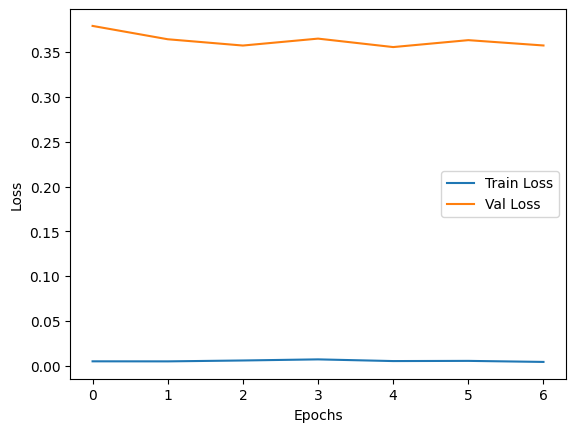

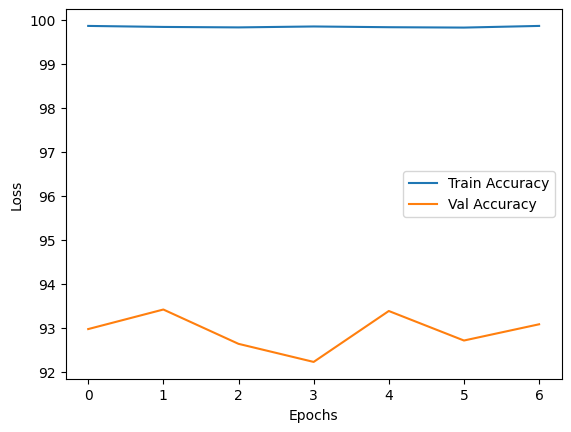

In [27]:
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(metrics['train_acc'], label='Train Accuracy')
plt.plot(metrics['val_acc'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()